In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [170]:
# Read and parse lines
books_col_list = ["ISBN", "Book-Title","Book-Author","Year-Of-Publication","Publisher"]
books = pd.read_csv("BX-Books.csv",usecols=books_col_list, header=0, sep=';', encoding='latin-1',low_memory=False)
users = pd.read_csv("./BX-Users.csv", sep=";", encoding='latin-1')
ratings = pd.read_csv("./BX-Book-Ratings.csv", sep=";", encoding='latin-1')

In [124]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
count,271379,271379,271378,271379,271377
unique,271379,242154,102042,137,16824
top,2253144894,Selected Poems,Agatha Christie,2002,Harlequin
freq,1,27,632,17627,7535


In [113]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [125]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


,Year-Of-Publication
count,264325.000000
mean,1993.966337
std,7.432902
min,1967.000000
25%,1989.000000
50%,1996.000000
75%,2000.000000
max,2020.000000


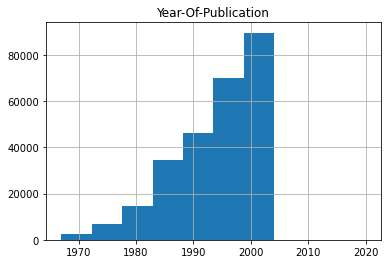

In [126]:
books = pd.read_csv("BX-Books.csv",usecols=books_col_list, header=0, sep=';', encoding='latin-1',low_memory=False)

def remove_book_outliers(books):
    # Filter by valid ISBN Regex
    books = books[books.ISBN.str.contains('^\d{9}[\d|X]$', regex=True)]
    books = books[books["Year-Of-Publication"].str.contains(r"^\d+$")]
    
    # Cast to numeric
    books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(int)
    
    # Keep only valid year of publication
    books = books[books["Year-Of-Publication"] <= 2020]
    books = books[books["Year-Of-Publication"] >= 1967]

    return books
    
books = remove_book_outliers(books)
books.hist(column="Year-Of-Publication")
books.describe()

,User-ID,Age
count,160766.000000,160766.000000
mean,139480.087711,35.417576
std,80504.363649,13.125263
min,2.000000,16.000000
25%,70058.250000,25.000000
50%,139545.500000,33.000000
75%,209155.500000,44.000000
max,278855.000000,79.000000


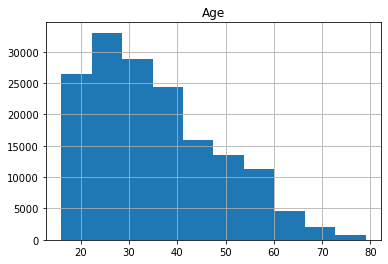

In [121]:
#Cleaning Users Data by droping irregular values and secifies the age ranges we need
def remove_user_outliers(users):
    users=users.loc[users['Age'] < 80.0]
    users=users.loc[users['Age'] > 15.0]
    
    return users
    
books = remove_user_outliers(users)
books.hist(column="Age")
books.describe()

In [34]:
#keeping unique ID values
users.drop_duplicates(subset=("User-ID"))

,User-ID,Location,Age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
12,13,"barcelona, barcelona, spain",26.0
...,...,...,...
278848,278849,"georgetown, ontario, canada",23.0
278850,278851,"dallas, texas, usa",33.0
278851,278852,"brisbane, queensland, australia",32.0
278852,278853,"stranraer, n/a, united kingdom",17.0


Before removing books with outlying read counts:  270170
After removing books with outlying read counts: 267753
Removed outliers: 2417


array([[<AxesSubplot:title={'center':'User-ID'}>]], dtype=object)

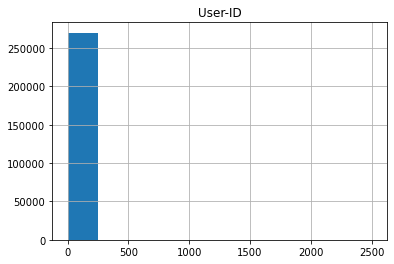

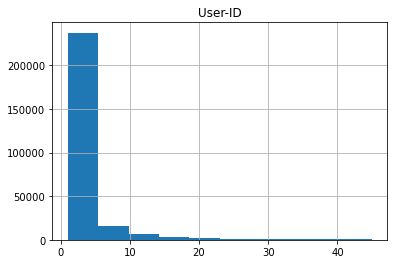

In [182]:
# Merge ratings with books
books_ratings = pd.merge(ratings, books, how="inner", left_on='ISBN', right_on='ISBN')
books_read_count = books_ratings.groupby("ISBN").count()
books_read_count.hist(column="User-ID")
print("Before removing books with outlying read counts: ", books_read_count['User-ID'].count())

# Remove outlying user_id counts by z_scores
std = books_read_count['User-ID'].std()
mean = books_read_count['User-ID'].mean()
books_read_count['User-ID-Z-Score'] = (books_read_count['User-ID'] - mean) / std
books_read_count_outliers = books_read_count[books_read_count['User-ID-Z-Score'].abs() > 3]
books_read_count = books_read_count[books_read_count['User-ID-Z-Score'].abs() < 3]
print("After removing books with outlying read counts:", books_read_count['User-ID'].count())
print("Removed outliers:", books_read_count_outliers['User-ID'].count())

books_read_count.hist(column="User-ID")

#books_read_count["User-ID"].describe()
#books_read_count['User-ID-Z-Score'].describe()

   User-ID        ISBN  Book-Rating            Book-Title Book-Author  \
0   276725  034545104X            0  Flesh Tones: A Novel  M. J. Rose   
1     2313  034545104X            5  Flesh Tones: A Novel  M. J. Rose   
2     6543  034545104X            0  Flesh Tones: A Novel  M. J. Rose   
3     8680  034545104X            5  Flesh Tones: A Novel  M. J. Rose   
4    10314  034545104X            9  Flesh Tones: A Novel  M. J. Rose   

  Year-Of-Publication         Publisher  
0                2002  Ballantine Books  
1                2002  Ballantine Books  
2                2002  Ballantine Books  
3                2002  Ballantine Books  
4                2002  Ballantine Books  
Before removing outliers with z_score:  270170
After removing user counts outliers with z_score: 267753
Removed outliers: 2417
After removing rating counts outliers with z_score: 261269
Removed outliers: 6484
After removing rating counts outliers with z_score: 252691
Removed outliers: 8578


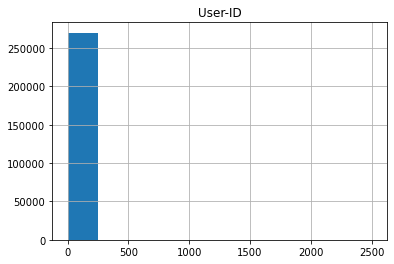

In [37]:
authors_c = authors_m.groupby("Book-Author").count()
age = authors_m.groupby("Book-Author").count()
del authors_c["User-ID"]
del authors_c["ISBN"]
print("The top 20 Authors sorted by popularity based on book ratings:")
authors_c.sort_values(["Book-Rating"],ascending=False).head(20)

The top 20 Authors sorted by popularity based on book ratings:


,Book-Rating
Book-Author,
Stephen King,7432
Nora Roberts,6123
John Grisham,4071
James Patterson,3675
Mary Higgins Clark,3261
Dean R. Koontz,3150
Tom Clancy,2681
Danielle Steel,2658
Sue Grafton,2410


In [38]:
btitles_c = btitles_m.groupby("Book-Title").count()
del btitles_c["User-ID"]
del btitles_c["ISBN"]
print("The top 20 Books sorted by popularity based on book ratings:")
btitles_c.sort_values(["Book-Rating"],ascending=False).head(20)

The top 20 Books sorted by popularity based on book ratings:


,Book-Rating
Book-Title,
Wild Animus,2070
The Lovely Bones: A Novel,905
The Da Vinci Code,694
Bridget Jones's Diary,597
Angels &amp; Demons,541
The Secret Life of Bees,537
A Painted House,509
Life of Pi,507
Divine Secrets of the Ya-Ya Sisterhood: A Novel,506


In [39]:
merge_users_with_ratings= pd.merge(ratings, users, how="inner", left_on='User-ID', right_on='User-ID')
ages_m = merge_users_with_ratings[["User-ID","Age", "ISBN", "Book-Rating"]].copy()

In [40]:
ages_c=ages_m.groupby("Age").count()
del ages_c["User-ID"]
del ages_c["ISBN"]
print("The top 20 Ages sorted by popularity based on book ratings:")
ages_c.sort_values(["Book-Rating"],ascending=False).head(20)

The top 20 Ages sorted by popularity based on book ratings:


,Book-Rating
Age,
33.0,31944
29.0,29699
30.0,26328
32.0,25615
36.0,25286
28.0,25144
31.0,25121
34.0,25103
38.0,21671


In [41]:
user_groupby = ratings.groupby("User-ID")
book_groupby = ratings.groupby("ISBN")
avg_user_rating = user_groupby["Book-Rating"].mean()
print(avg_user_rating)

User-ID
2         0.000000
10        0.000000
20        0.000000
36        0.000000
42        7.000000
            ...   
278844    6.000000
278846    8.000000
278849    3.000000
278851    3.909091
278852    8.000000
Name: Book-Rating, Length: 50327, dtype: float64


In [42]:
std_user_rating = user_groupby["Book-Rating"].std()
std_user_rating= std_user_rating.dropna(axis=0,how='any')
print(std_user_rating)

User-ID
44        3.577709
56        4.725816
67        3.500000
75        2.886751
85        3.535534
            ...   
278832    0.000000
278843    3.662072
278844    0.000000
278849    5.196152
278851    3.530939
Name: Book-Rating, Length: 24922, dtype: float64


In [119]:
# Calculating upper and lower limits
def show_outliers():
 upper_limit= ratings["Book-Rating"].mean()+3*ratings["Book-Rating"].std()
lower_limit= ratings["Book-Rating"].mean()-3*ratings["Book-Rating"].std()    
 outliers = ratings[(ratings['Book-Rating'] > upper_limit) | (ratings["Book-Rating"]<lower_limit) ].index
print(outliers)
outliers.shape()


IndentationError: unexpected indent (<ipython-input-119-2547777ee0f4>, line 5)

In [ ]:
avg_book_rating = book_groupby["Book-Rating"].mean()
print(avg_book_rating)

In [ ]:
author=authors_m.groupby("Book-Author")
avg_authors_rating=author["Book-Rating"].mean()
print(avg_authors_rating)

In [ ]:
# Remove Outliers
def remove_outliers(dataframe):

    # Calculating upper and lower limits
    upperlimit=dataframe["Book-Rating"].mean()+3*dataframe['Book-Rating'].std()
    lowerlimit=dataframe["Book-Rating"].mean()-3*dataframe['Book-Rating'].std()
    
    # Remove outliers
    outliers = dataframe[(dataframe['Book-Rating'] > upper_limit) | (dataframe["Book-Rating"]<lower_limit) ].index
    dataframe = dataframe.drop(outliers)

    return dataframe

In [ ]:


# cosine similarity of users u and v
def csim(u, v):
    return (np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))


# Pearson similarity of users u and v
def psim(u, v):
    return csim(u - np.mean(u), v - np.mean(v))


# calc_similarities(r, sim)
# r: ratings table, users x items
# sim: similarity measure to be used, default csim
# calculates similarities between all user pairs
# returns table u x u, [i, j] element is similarity of ui and uj
## pip install scikit-learn
## from sklearn.metrics.pairwise import cosine_similarity
## return cosine_similarity(r)
def calc_similarities(r, sim=csim):

    print("[>] Calculating similarities...")

    return np.corrcoef(r.T, rowvar=False)


# calc_neighbourhood(s, k)
# s: similarities matrix, u x u, symmetric
# k: size of neighbourhood
# returns u x k, for each user u the k most similar users
def calc_neighbourhood(s, k):

    print("[>] Calculating neighbourhood...")

    return np.array([[x for x in np.argsort(s[i]) if x != i][len(s) - 1: len(s) - k - 2: -1] for i in range(len(s))])


# predict(userId, itemId, r, s, n)
# r: ratings table, user x item
# s: similarities matrix, user x user
# nb: neighbourhood table, user x k
# returns prediction for userId, itemId
def predict(userId, itemId, r, s, nb):
    rsum, ssum = 0.0, 0.0
    for n in nb[userId]:
        rsum += s[userId][n] * (r[n][itemId] - np.mean(r[n]))
        ssum += s[userId][n]
    return np.mean(r[userId]) + rsum / ssum


# mae(p, a) returns the mean average error between
# predictions p and actual ratings a
def mae(p, a):
    return sum(map(lambda x: abs(x[0] - x[1]), zip(p, a))) / len(p)


# rmse(p, a) returns the root mean square error between
# predictions p and actual ratings a
def rmse(p, a):
    return math.sqrt(sum(map(lambda x: (x[0] - x[1]) ** 2, zip(p, a))) / len(p))


# flatten(l) flattens a list of lists l
def flatten(l):
    return np.array([x for r in l for x in r])



In [ ]:
       start_time = datetime.datetime.now()
    

        r = generate_ratings_matrix(ratings)

        s = calc_similarities(r)
        export_to_csv(s, "user-pairs-books.data.csv")

        nb = calc_neighbourhood(s, 2)
        export_to_csv(nb, "neighbors-k-books.data.csv")

        print("[>] Computing recommendations...")
        pr = [[predict(u, i, r, s, nb) for i in range(len(r[u]))] for u in range(len(r))]
        print("[>] Computations completed !\n")
        
        print('[>] Mean Average Error: {:.4f}'.format(mae(flatten(r), flatten(pr))))
        print('[>] Root Mean Square Error: {:.4f}\n'.format(rmse(flatten(r), flatten(pr))))

        end_time = datetime.datetime.now()